## 聚类

### 1. Partitional Clustering & Hierarchical clustering

1. Partitional Clustering：将数据划分为非重叠的子集，每一个子集为一个聚类。

2. Hierarchical clustering：层次聚类，所有聚类之间通过树结构进行关联。每个聚类相当于叶子结点。根节点包含所有的聚类。

**A hierarchical clustering can be viewed as a sequence of partitional clustering and a partitional clustering can be obtained by taking any member of the that sequences by cutting the hierarchical tree at a particular level.**

### 2. 聚类算法：

### 2.1 k-means：

<img src="image_github/k-means.png" width="500" height="500">

**缺点：对初始化点非常敏感。**
<img src="image_github/k-means_example.png" width="300" height="300">

### 2.2 k-means++：

1. 随机选择数据集中某一点作为第一个聚类中心。
2. 计算数据集中所有点距离此聚类中心的距离。
3. **根据概率，随机选择**距离较大的点作为第二个聚类中心。
4. 重复2，3步骤。直到选择出k个聚类中心。
5. 将k个聚类中心作为k-means算法初始值。

**注意：随机选择距离较大的点可以避免噪声。**
<img src="image_github/k-means_plus.png" width="400" height="400">
<img src="image_github/k-means_explain.png" width="400" height="400">

**缺点：无法处理大数据量。**

### 2.3 k-means||：

k-means||与k-means++的区别在于第三步，k-means||根据概率一次随机选择出多个距离较大的点，重复多次，使用这些被选择的点进行k-means后，获得k个聚类中心。然后使用这些点作为k-means的初始值。

<img src="image_github/k-means2_1.png" width="300" height="300">
<img src="image_github/k-means2_2.png" width="300" height="300">
<img src="image_github/k-means2_3.png" width="300" height="300">

### 3. 评估聚类算法：

方法：**轮廓系数(Silhouette)**，Silhouette系数是对聚类结果有效性的解释和验证。

* 簇内不相似度：计算样本i到同簇其他样本的平均距离ai。ai越小，说明样本i越应该被聚类到该簇。将ai称为样本i的簇内不相似度。簇C中所有样本的ai均值称为簇C的簇不相似度。


* 簇间不相似度：计算样本i到其他某簇Cj的所有样本的平均距离bij，称为样本i与簇Cj 的不相似度。定义为样本i的簇间不相似度：bi = min{bi1, bi2, ..., bik}


* 根据样本i的簇内不相似度a i 和簇间不相似度b i ，定义样本i的轮廓系数：

<img src="image_github/Silhouette.png" width="400" height="400">

**si接近1，则说明样本i聚类合理；si接近-1，则说明样本i更应该分类到另外的簇；若si 近似为0，则说明样本i在两个簇的边界上。**

### 3. pyspark:

In [1]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

In [2]:
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Kmeans clustering") \
    .getOrCreate()

In [4]:
df = spark.read.load("../Data/iris.csv", format="csv", inferSchema="true", header="true")
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [5]:
df.show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|         5.0|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
|         5.4|        3.7|         1.5|        0.2| setosa|
|         4.8|        3.4|         1.6|        0.2| setosa|
|         4.8|        3.0|         1.4|        0.1| setosa|
|         4.3|        3.0|         1.1| 

In [7]:
from pyspark.ml.linalg import Vectors
# convert the data to dense vector because ml api only accept this type.
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

dfFtrvec= transData(df)
dfFtrvec.show(5, False)

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



In [8]:
# 层次聚类
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans().setK(16).setMinDivisibleClusterSize(4).setSeed(1234)
model = bkm.fit(dfFtrvec)
predictions = model.transform(dfFtrvec)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette

0.3646595969004409

**k-means||：.setInitMode("k-means||") 或 k-means++：.setInitMode("random")**

In [9]:
import numpy as np
numK=10
silhouettes = np.zeros(numK)
costs= np.zeros(numK)
for k in range(2,numK):
    kmeans = KMeans().setK(k).setSeed(11) # .setInitMode("k-means||") .setInitMode("random")
    model = kmeans.fit(dfFtrvec)
    # Make predictions, i.e., get cluster index
    predictions = model.transform(dfFtrvec)
    # K-means cost (sum of squared distances of points to their nearest center)
    costs[k]=model.computeCost(dfFtrvec)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouettes[k] = evaluator.evaluate(predictions)

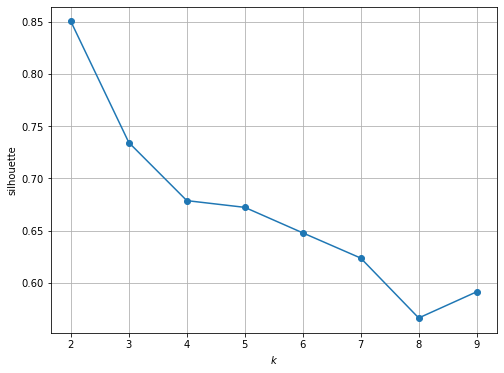

In [12]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,numK),silhouettes[2:numK],marker="o")
ax.set_xlabel('$k$')
ax.set_ylabel('silhouette')
plt.grid()
plt.show()

**注意此处使用silhouette指标选择模型，而不是cost（sum of squared distances）。**

## RFM分析：

**RFM模型是网点衡量当前用户价值和客户潜在价值的重要工具和手段。RFM是Rencency（最近一次消费），Frequency（消费频率）、Monetary（消费金额）。**

**R值：最近一次消费（Recency），F值：消费频率（Frequency），M值：消费金额（Monetary）。**

In [46]:
df_raw = spark.read.load("../Data/online_retail.csv", format="csv", inferSchema="true", header="true")

In [47]:
df_raw.show(10)

+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|_c0|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  0|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|  1|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  2|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|  3|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  4|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|  5|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United K

In [48]:
df_raw.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [49]:
df = df_raw.dropna(how='any') 

In [50]:
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

timeFmt = "MM/dd/yy HH:mm"
df = df.withColumn('NewInvoiceDate', \
                   to_utc_timestamp(unix_timestamp(col('InvoiceDate'), timeFmt).cast('timestamp') , 'UTC'))

In [51]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- NewInvoiceDate: timestamp (nullable = true)



In [52]:
from pyspark.sql.functions import round

df = df.withColumn('TotalPrice', round(df['Quantity'] * df['UnitPrice'], 2))

In [53]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- NewInvoiceDate: timestamp (nullable = true)
 |-- TotalPrice: double (nullable = true)



In [68]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date

date_max = df.select(max('NewInvoiceDate')).collect()

current = to_utc_timestamp(unix_timestamp(lit(str(date_max[0][0])),'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )

# Calculatre Duration
df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))

In [69]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- NewInvoiceDate: timestamp (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- Duration: integer (nullable = true)



In [70]:
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency')) 

In [72]:
recency.show()

+----------+-------+
|CustomerID|Recency|
+----------+-------+
|   16916.0|     23|
|   17884.0|      3|
|   13094.0|     21|
|   16596.0|     15|
|   17633.0|     31|
|   18114.0|    290|
|   13973.0|    287|
|   14473.0|     74|
|   13956.0|      5|
|   13533.0|    182|
|   13918.0|     49|
|   12493.0|    165|
|   14285.0|     21|
|   15776.0|    133|
|   14768.0|     17|
|   17267.0|    127|
|   14024.0|    121|
|   16629.0|     73|
|   14452.0|     10|
|   16561.0|      5|
+----------+-------+
only showing top 20 rows



In [74]:
from pyspark.sql.functions import count

frequency = df.groupBy('CustomerID', 'InvoiceNo').count().groupBy('CustomerID').agg(count("*").alias("Frequency"))

In [75]:
frequency.show()

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|   13094.0|       16|
|   17884.0|        4|
|   16561.0|        2|
|   13973.0|        1|
|   14285.0|        4|
|   17633.0|        6|
|   13956.0|        5|
|   13533.0|        3|
|   13918.0|        2|
|   12493.0|        3|
|   17267.0|        2|
|   14768.0|        3|
|   15776.0|        1|
|   16629.0|        2|
|   14473.0|        2|
|   18114.0|        1|
|   13607.0|        1|
|   16596.0|        2|
|   14024.0|        2|
|   14452.0|        2|
+----------+---------+
only showing top 20 rows



In [76]:
monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))

In [77]:
monetary.show()

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|   16916.0|  576.26|
|   17884.0|  717.45|
|   13094.0| 1708.86|
|   16596.0|  250.15|
|   17633.0| 1242.34|
|   18114.0|   220.1|
|   13973.0|   264.7|
|   14473.0|  234.34|
|   13956.0| 1026.42|
|   13533.0|  270.79|
|   13918.0| 1212.84|
|   12493.0|  416.79|
|   14285.0| 1910.01|
|   15776.0|  241.62|
|   14768.0|   139.5|
|   17267.0|  317.62|
|   14024.0|   327.7|
|   16629.0|  417.73|
|   14452.0|  264.44|
|   16561.0|  511.12|
+----------+--------+
only showing top 20 rows



In [78]:
rfm = recency.join(frequency,'CustomerID', how = 'inner').join(monetary,'CustomerID', how = 'inner')

In [79]:
rfm.show()

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|   13094.0|     21|       16| 1708.86|
|   17884.0|      3|        4|  717.45|
|   16561.0|      5|        2|  511.12|
|   13973.0|    287|        1|   264.7|
|   14285.0|     21|        4| 1910.01|
|   17633.0|     31|        6| 1242.34|
|   13956.0|      5|        5| 1026.42|
|   13533.0|    182|        3|  270.79|
|   13918.0|     49|        2| 1212.84|
|   12493.0|    165|        3|  416.79|
|   17267.0|    127|        2|  317.62|
|   14768.0|     17|        3|   139.5|
|   15776.0|    133|        1|  241.62|
|   16629.0|     73|        2|  417.73|
|   14473.0|     74|        2|  234.34|
|   18114.0|    290|        1|   220.1|
|   13607.0|     40|        1|  678.01|
|   16596.0|     15|        2|  250.15|
|   14024.0|    121|        2|   327.7|
|   14452.0|     10|        2|  264.44|
+----------+-------+---------+--------+
only showing top 20 rows



### Determine cutting points

**利用RFM模型的三个属性对客户进行打分，通过打分确定每个用户的质量，最终筛选出自己的目标用户。**

<img src="image_github/rfm.png" width="500" height="500">

**计算每个客户RFM三个指标的得分，计算每个客户的总得分，并且根据总得分筛选出优质的客户。**

https://www.jianshu.com/p/4b60880f24e2

In [80]:
def RScore(x): 
    if x<=16: return 1 
    elif x<= 50: return 2
    elif x<= 143: return 3
    else: return 4
    
def FScore(x): 
    if x<=1: return 4 
    elif x <= 3: return 3 
    elif x <= 5: return 2
    else: return 1
    
def MScore(x):
    if x<=293: return 4 
    elif x <= 648: return 3 
    elif x <= 1611: return 2 
    else: return 1
    
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType()) 
F_udf = udf(lambda x: FScore(x), StringType()) 
M_udf = udf(lambda x: MScore(x), StringType())

In [81]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency")) 
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency")) 
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary")) 
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|   13094.0|     21|       16| 1708.86|    2|    1|    1|
|   17884.0|      3|        4|  717.45|    1|    2|    2|
|   16561.0|      5|        2|  511.12|    1|    3|    3|
|   13973.0|    287|        1|   264.7|    4|    4|    4|
|   14285.0|     21|        4| 1910.01|    2|    2|    1|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [83]:
from pyspark.sql import functions as F
    
rfm_seg = rfm_seg.withColumn('RFMScore', F.concat(F.col('r_seg'), F.col('f_seg'), F.col('m_seg'))) 

rfm_seg.sort(F.col('RFMScore')).show(5)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|   13458.0|      7|       22| 9537.92|    1|    1|    1|     111|
|   16353.0|      3|       23| 6675.71|    1|    1|    1|     111|
|   15750.0|      2|        9| 2451.23|    1|    1|    1|     111|
|   17659.0|      3|       14| 2954.75|    1|    1|    1|     111|
|   15311.0|      0|      118|59419.34|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



In [85]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

# Method 2 (good for large features):
def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

In [86]:
transformed = transData(rfm) 
transformed.show(5)

+----------+-------------------+
|CustomerID|                rfm|
+----------+-------------------+
|   13094.0|[21.0,16.0,1708.86]|
|   17884.0|   [3.0,4.0,717.45]|
|   16561.0|   [5.0,2.0,511.12]|
|   13973.0|  [287.0,1.0,264.7]|
|   14285.0| [21.0,4.0,1910.01]|
+----------+-------------------+
only showing top 5 rows



### 数据归一化处理：

In [91]:
from pyspark.ml.feature import MinMaxScaler 

scaler = MinMaxScaler(inputCol="rfm",outputCol="features")
scalerModel = scaler.fit(transformed) 
scaledData = scalerModel.transform(transformed) 
scaledData.show(5,False)

+----------+-------------------+----------------------------------------------------------------+
|CustomerID|rfm                |features                                                        |
+----------+-------------------+----------------------------------------------------------------+
|13094.0   |[21.0,16.0,1708.86]|[0.05630026809651475,0.06072874493927125,0.0211310197650159]    |
|17884.0   |[3.0,4.0,717.45]   |[0.00804289544235925,0.012145748987854251,0.017637391941866955] |
|16561.0   |[5.0,2.0,511.12]   |[0.013404825737265416,0.004048582995951417,0.016910306045264823]|
|13973.0   |[287.0,1.0,264.7]  |[0.7694369973190348,0.0,0.016041947073517148]                   |
|14285.0   |[21.0,4.0,1910.01] |[0.05630026809651475,0.012145748987854251,0.021839851869419134] |
+----------+-------------------+----------------------------------------------------------------+
only showing top 5 rows



In [92]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler 
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce # For Python 3.x
from pyspark.ml.clustering import KMeans

In [94]:
import numpy as np 
cost = np.zeros(20) 
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(scaledData)
    cost[k] = model.computeCost(scaledData) # requires Spark 2.0 or later

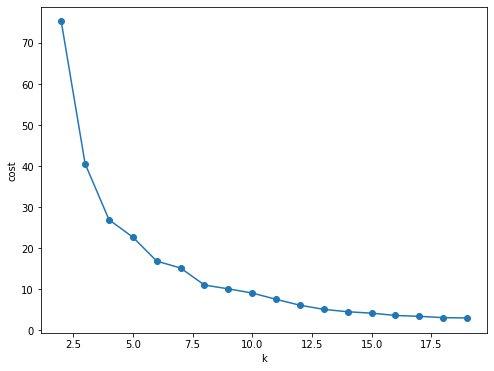

In [98]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize =(8,6)) 
ax.plot(range(2,20),cost[2:20], marker = "o") 
ax.set_xlabel('k')
ax.set_ylabel('cost') 
plt.show()

In [99]:
k=3
kmeans = KMeans().setK(k).setSeed(1) 
model = kmeans.fit(scaledData)
# Make predictions
predictions = model.transform(scaledData) 
predictions.show(5,False)

+----------+-------------------+----------------------------------------------------------------+----------+
|CustomerID|rfm                |features                                                        |prediction|
+----------+-------------------+----------------------------------------------------------------+----------+
|13094.0   |[21.0,16.0,1708.86]|[0.05630026809651475,0.06072874493927125,0.0211310197650159]    |0         |
|17884.0   |[3.0,4.0,717.45]   |[0.00804289544235925,0.012145748987854251,0.017637391941866955] |0         |
|16561.0   |[5.0,2.0,511.12]   |[0.013404825737265416,0.004048582995951417,0.016910306045264823]|0         |
|13973.0   |[287.0,1.0,264.7]  |[0.7694369973190348,0.0,0.016041947073517148]                   |1         |
|14285.0   |[21.0,4.0,1910.01] |[0.05630026809651475,0.012145748987854251,0.021839851869419134] |0         |
+----------+-------------------+----------------------------------------------------------------+----------+
only showing top 5 